In [1]:
# Chaitra Pirisingula
# Shruti Pradeep
# 04/10/2023 

In [2]:
from ColorBlindnessAnalysis import simulate_colorblindness, get_colors, get_color_similarity_scores, display_charts, replace_color
from ColorMasks import protanopia_simulation_matrix, deuteranopia_simulation_matrix, tritanopia_simulation_matrix
import cv2

In [3]:
cb_masks = [protanopia_simulation_matrix, deuteranopia_simulation_matrix, tritanopia_simulation_matrix]
cb_names = ["Protanopia", "Deuteranopia", "Tritanopia"]

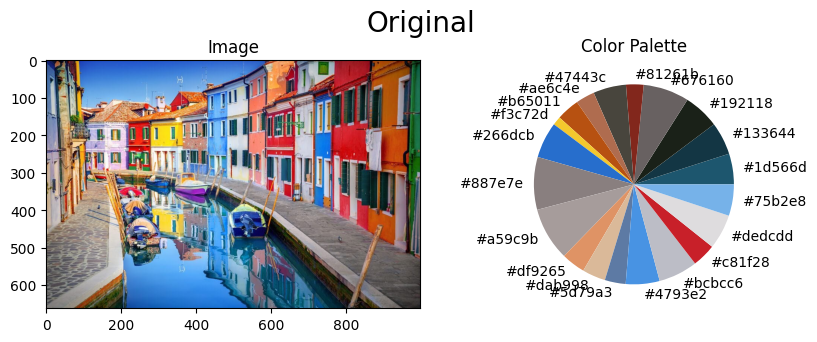

In [4]:
# Load original image
image = cv2.imread('images/houses.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get original colors and corresponding colorblindness colors with delta e scores
original_colors = get_colors(image, 20, "Original")
cb_scores = get_color_similarity_scores(original_colors, cb_names, cb_masks)

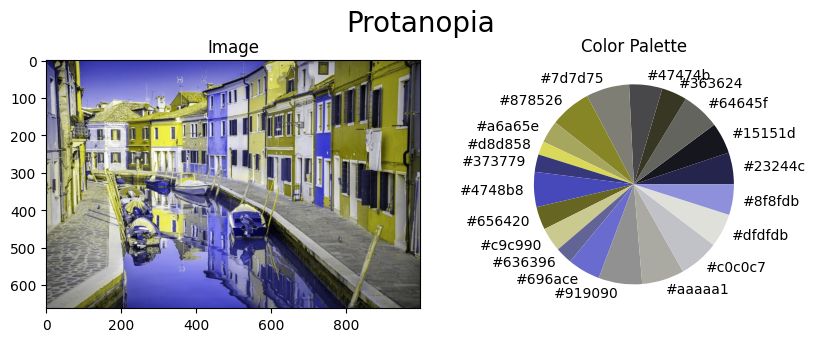

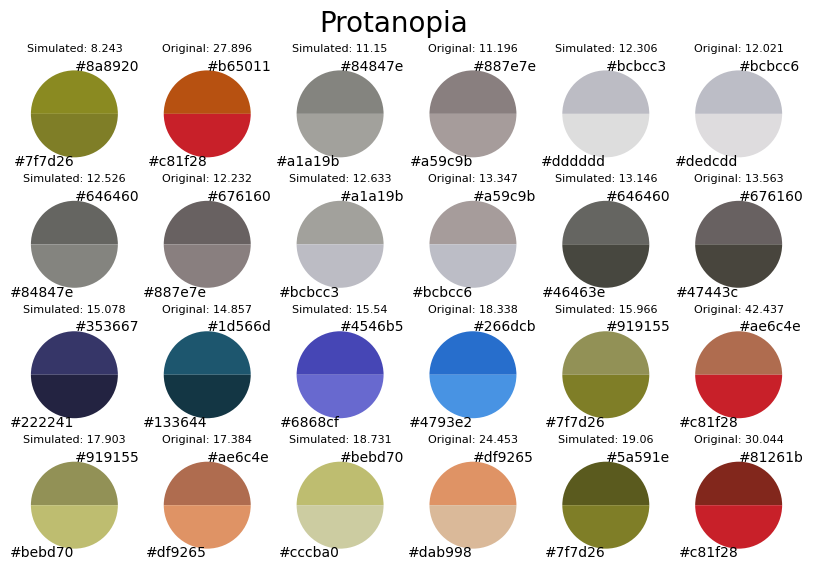

In [5]:
# Simulate Protanopia and display results 
protanopia_image = simulate_colorblindness(protanopia_simulation_matrix, image)
protanopia_colors = get_colors(protanopia_image, 20, cb_names[0])
display_charts(cb_names[0], cb_scores[cb_names[0]])

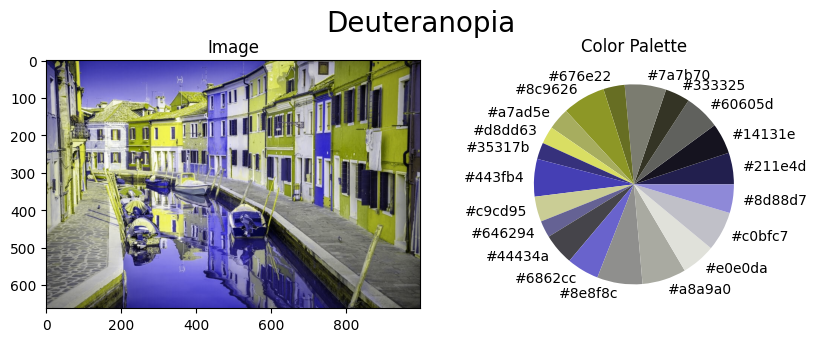

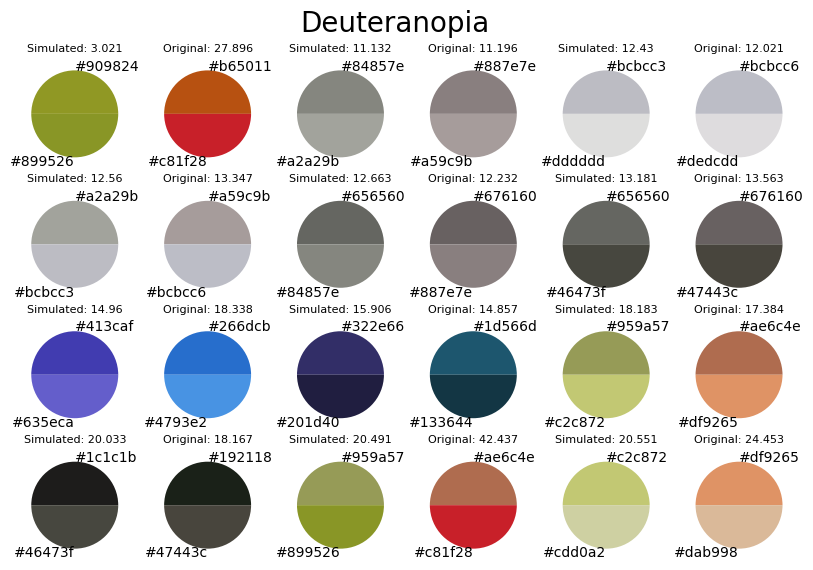

In [6]:
# Simulate Deuteranopia and display results 
deuteranopia_image = simulate_colorblindness(deuteranopia_simulation_matrix, image)
deuteranopia_colors = get_colors(deuteranopia_image, 20, cb_names[1])
display_charts(cb_names[1], cb_scores[cb_names[1]])

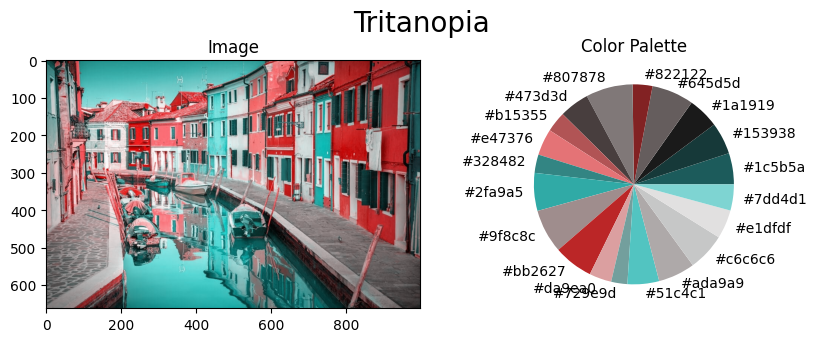

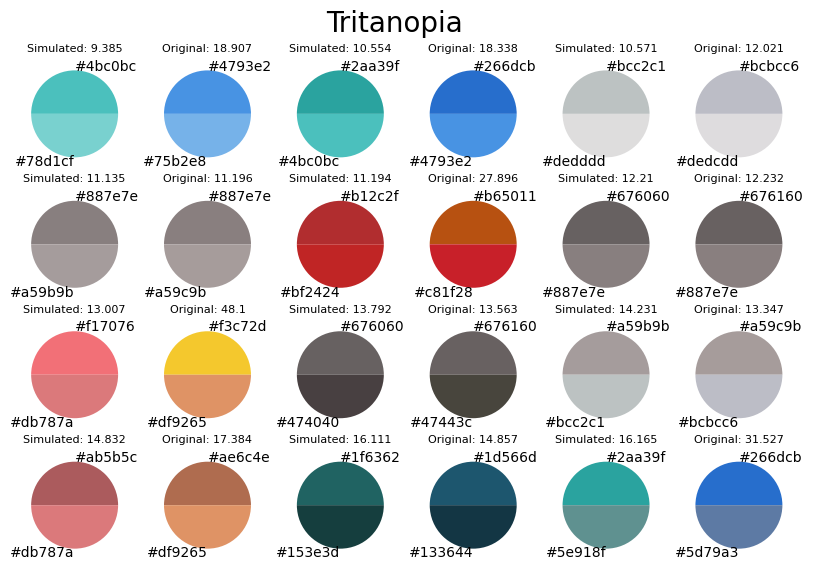

In [7]:
# Simulate Tritanopia and display results 
tritanopia_image = simulate_colorblindness(tritanopia_simulation_matrix, image)
tritanopia_colors = get_colors(tritanopia_image, 20, cb_names[2])
display_charts(cb_names[2], cb_scores[cb_names[2]])

In [ ]:
import numpy as np

# Color ranges (in HSV format)
lower_blue = np.array([100, 50, 50]) 
upper_blue = np.array([130, 255, 255]) 

lower_green = np.array([60, 25, 0])
upper_green = np.array([180, 255, 255])

lower_red1 = np.array([0, 25, 0])
upper_red1 = np.array([30, 255, 255])
lower_red2 = np.array([150, 25, 0])
upper_red2 = np.array([180, 255, 255])

lower_yellow = np.array([30, 25, 0])
upper_yellow = np.array([60, 255, 255]) 

lower_orange1 = np.array([0, 25, 0])
upper_orange1 = np.array([30, 255, 255])
lower_orange2 = np.array([160, 25, 0])
upper_orange2 = np.array([180, 255, 255])

# BGR formatted colors
red = np.array([0, 0, 255])
blue = np.array([255, 0, 0])
green = np.array([0, 255, 0])

image = cv2.imread('images/home.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

original_colors = get_colors(image, 20, "Original")

protanopia_image = simulate_colorblindness(protanopia_simulation_matrix, image)
protanopia_colors = get_colors(protanopia_image, 20, cb_names[0])

tritanopia_image = simulate_colorblindness(tritanopia_simulation_matrix, image)
tritanopia_colors = get_colors(tritanopia_image, 20, cb_names[2])

# For protanopia and deuteranopia, replace green or red with blue
recolored_image = replace_color("images/home.png", lower_green, upper_green, blue)
recolored_colors = get_colors(recolored_image, 20, "Recolored")
protanopia_image = simulate_colorblindness(protanopia_simulation_matrix, recolored_image)
protanopia_colors = get_colors(protanopia_image, 20, cb_names[0])

# For tritanopia, replace blue or yellow with red
recolored_image = replace_color("images/home.png", lower_blue, upper_blue, red)
recolored_colors = get_colors(recolored_image, 20, "Recolored")
tritanopia_image = simulate_colorblindness(tritanopia_simulation_matrix, recolored_image)
tritanopia_colors = get_colors(tritanopia_image, 20, cb_names[2])
